## 4B. Training Refinement Network

In this stage we train the Refinement Network, which is a 1D MultiResUNet network.

The training in performed using 10 fold cross validation, and thus 10 models are obtained. 

Training the refinement network actually starts from loading the corresponding approximate network of that fold. After that approximate network has been loaded, the prediction by that network is computed and the refinement network is trained on that prediction to refine it further.

The models are stored in a *models* directory and also the training history gets stored in a *History* directory.

The file system becomes as follows

 .<br /> 
├── raw_data<br /> 
├── data<br /> 
├── History<br /> 
├── models<br /> 
│   ├── MultiResUNet1D_model2_fold0.h5<br />
│   ├── MultiResUNet1D_model2_fold1.h5<br />
│   ├── ...<br /> 
│   ├── MultiResUNet1D_model2_fold9.h5<br />
│   ├── UNetDS64_model1_fold0.h5<br /> 
│   ├── UNetDS64_model1_fold1.h5<br /> 
│   ├── ...<br /> 
│   └── UNetDS64_model1_fold9.h5<br /> 
└ ...


In [9]:
from helper_functions import *
from models import *
import time
from tqdm import tqdm
import pickle
import os
from tensorflow.keras.optimizers import Adam

"""
    Trains the refinement network in 10 fold cross validation manner
"""

model_dict = {}                                             # all the different models
model_dict['UNet'] = UNet
model_dict['UNetLite'] = UNetLite
model_dict['UNetWide40'] = UNetWide40
model_dict['UNetWide48'] = UNetWide48
model_dict['UNetDS64'] = UNetDS64
model_dict['UNetWide64'] = UNetWide64
model_dict['MultiResUNet1D'] = MultiResUNet1D
model_dict['MultiResUNetDS'] = MultiResUNetDS


mdlName1 = 'UNetDS64'                                       # approximation network
mdlName2 = 'MultiResUNet1D'                                 # refinement network

length = 1024                                               # length of the signal

                                                            # 10 fold cross validation
for foldname in range(1):

    print('----------------')
    print('Training Fold {}'.format(foldname+1))
    print('----------------')
                                                                                        # loading training data
    dt = pickle.load(open(os.path.join('data','train{}.p'.format(foldname)),'rb'))
    X_train = dt['X_train']
    Y_train = dt['Y_train']
                                                                                        # loading validation data
    dt = pickle.load(open(os.path.join('data','val{}.p'.format(foldname)),'rb'))
    X_val = dt['X_val']
    Y_val = dt['Y_val']

                                                                                        # loading metadata
    dt = pickle.load(open(os.path.join('data','meta{}.p'.format(foldname)),'rb'))
    max_ppg = dt['max_ppg']
    min_ppg = dt['min_ppg']
    max_abp = dt['max_abp']
    min_abp = dt['min_abp']


    Y_train = prepareLabel(Y_train)                                         # prepare labels for training deep supervision
    
    Y_val = prepareLabel(Y_val)                                             # prepare labels for training deep supervision

    mdl1 = model_dict[mdlName1](length)             # create approximation network
    
    # mdl1.load_weights(os.path.join('models','ApproximateNetwork.h5'))   # loading weights

    # 冻住网络前40层，只训练之后的网络层
    # for layer,i in zip(mdl1.layers,range(1,11)):
    #     # print(layer)
    #     layer.trainable = False
    
    # loss = mae, with deep supervision weights
    mdl1.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mean_squared_error'], loss_weights=[1., 0.9, 0.8, 0.7, 0.6])                                                         


    checkpoint1_ = ModelCheckpoint(os.path.join('models','{}_model1_fold{}.h5'.format(mdlName1,foldname)), verbose=1, monitor='val_out_loss',save_best_only=True, mode='auto')  
                                                                    # train approximation network for 100 epochs
    history1 = mdl1.fit(X_train,{'out': Y_train['out'], 'level1': Y_train['level1'], 'level2':Y_train['level2'], 'level3':Y_train['level3'] , 'level4':Y_train['level4']},epochs=100,batch_size=256,validation_data=(X_val,{'out': Y_val['out'], 'level1': Y_val['level1'], 'level2':Y_val['level2'], 'level3':Y_val['level3'] , 'level4':Y_val['level4']}),callbacks=[checkpoint1_],verbose=1)

    pickle.dump(history1.history, open('History/{}_model1_fold{}.p'.format(mdlName1,foldname),'wb'))    # save training history

    # save_model(history1, open('History/{}_model1_fold{}.p'.format(mdlName1,foldname),'wb'))       # save training history

    mdl1 = None                                             # garbage collection

    time.sleep(10)                                          # pause execution for a while to free the gpu
    
    

----------------
Training Fold 1
----------------


Preparing Label for DS: 100%|██████████| 10/10 [00:00<00:00, 113.58it/s]


Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 4.4669 - out_loss: 0.9019 - level1_loss: 1.1165 - level2_loss: 1.2034 - level3_loss: 1.1290 - level4_loss: 1.3451 - out_mean_squared_error: 1.4878 - level1_mean_squared_error: 2.2863 - level2_mean_squared_error: 2.4597 - level3_mean_squared_error: 2.0529 - level4_mean_squared_error: 2.8824 - val_loss: 1.4952 - val_out_loss: 0.3991 - val_level1_loss: 0.3903 - val_level2_loss: 0.3895 - val_level3_loss: 0.3449 - val_level4_loss: 0.3197 - val_out_mean_squared_error: 0.1782 - val_level1_mean_squared_error: 0.1709 - val_level2_mean_squared_error: 0.1701 - val_level3_mean_squared_error: 0.1371 - val_level4_mean_squared_error: 0.1187

Epoch 00001: val_out_loss improved from inf to 0.39912, saving model to models\UNetDS64_model1_fold0.h5
Epoch 2/100
1/1 [==============================] - 0s 339ms/step - loss: 11.7030 - out_loss: 0.9595 - level1_loss: 1.9637 - level2_loss: 2.0850 - level3_loss: 3.7194 - level4_loss: 7.8412 -

In [10]:
from helper_functions import *
from models import UNetDS64, MultiResUNet1D
import os
from predict_test import predict_test_data

predict_test_data()

1/1 [==============================] - 2s 2s/step


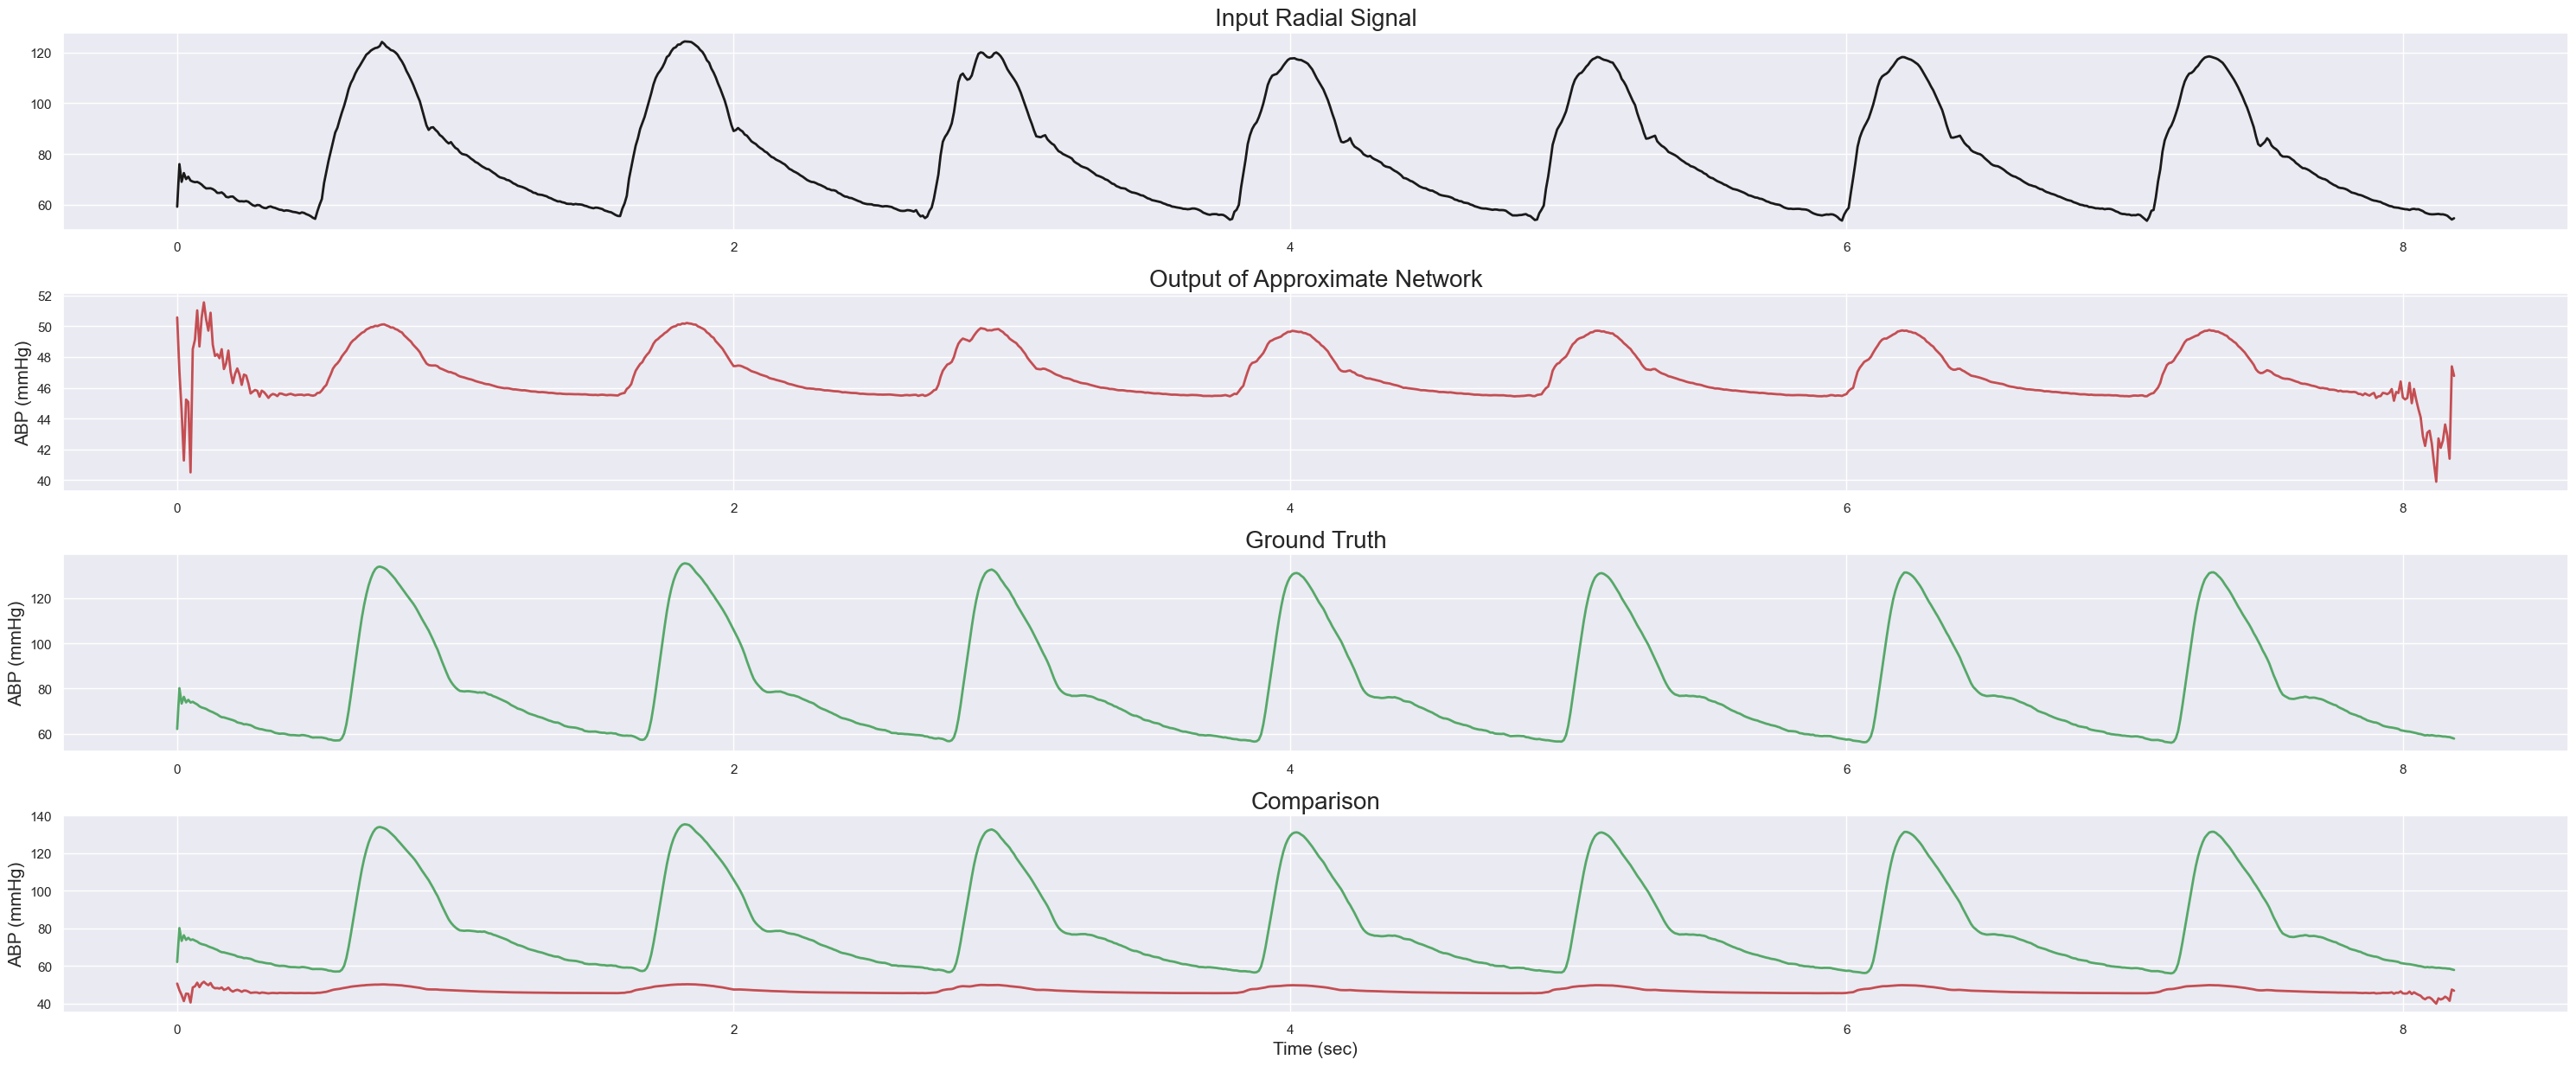

ValueError: invalid literal for int() with base 10: ''

In [11]:
#冻住前10层
from evaluate import predicting_ABP_waveform

predicting_ABP_waveform()

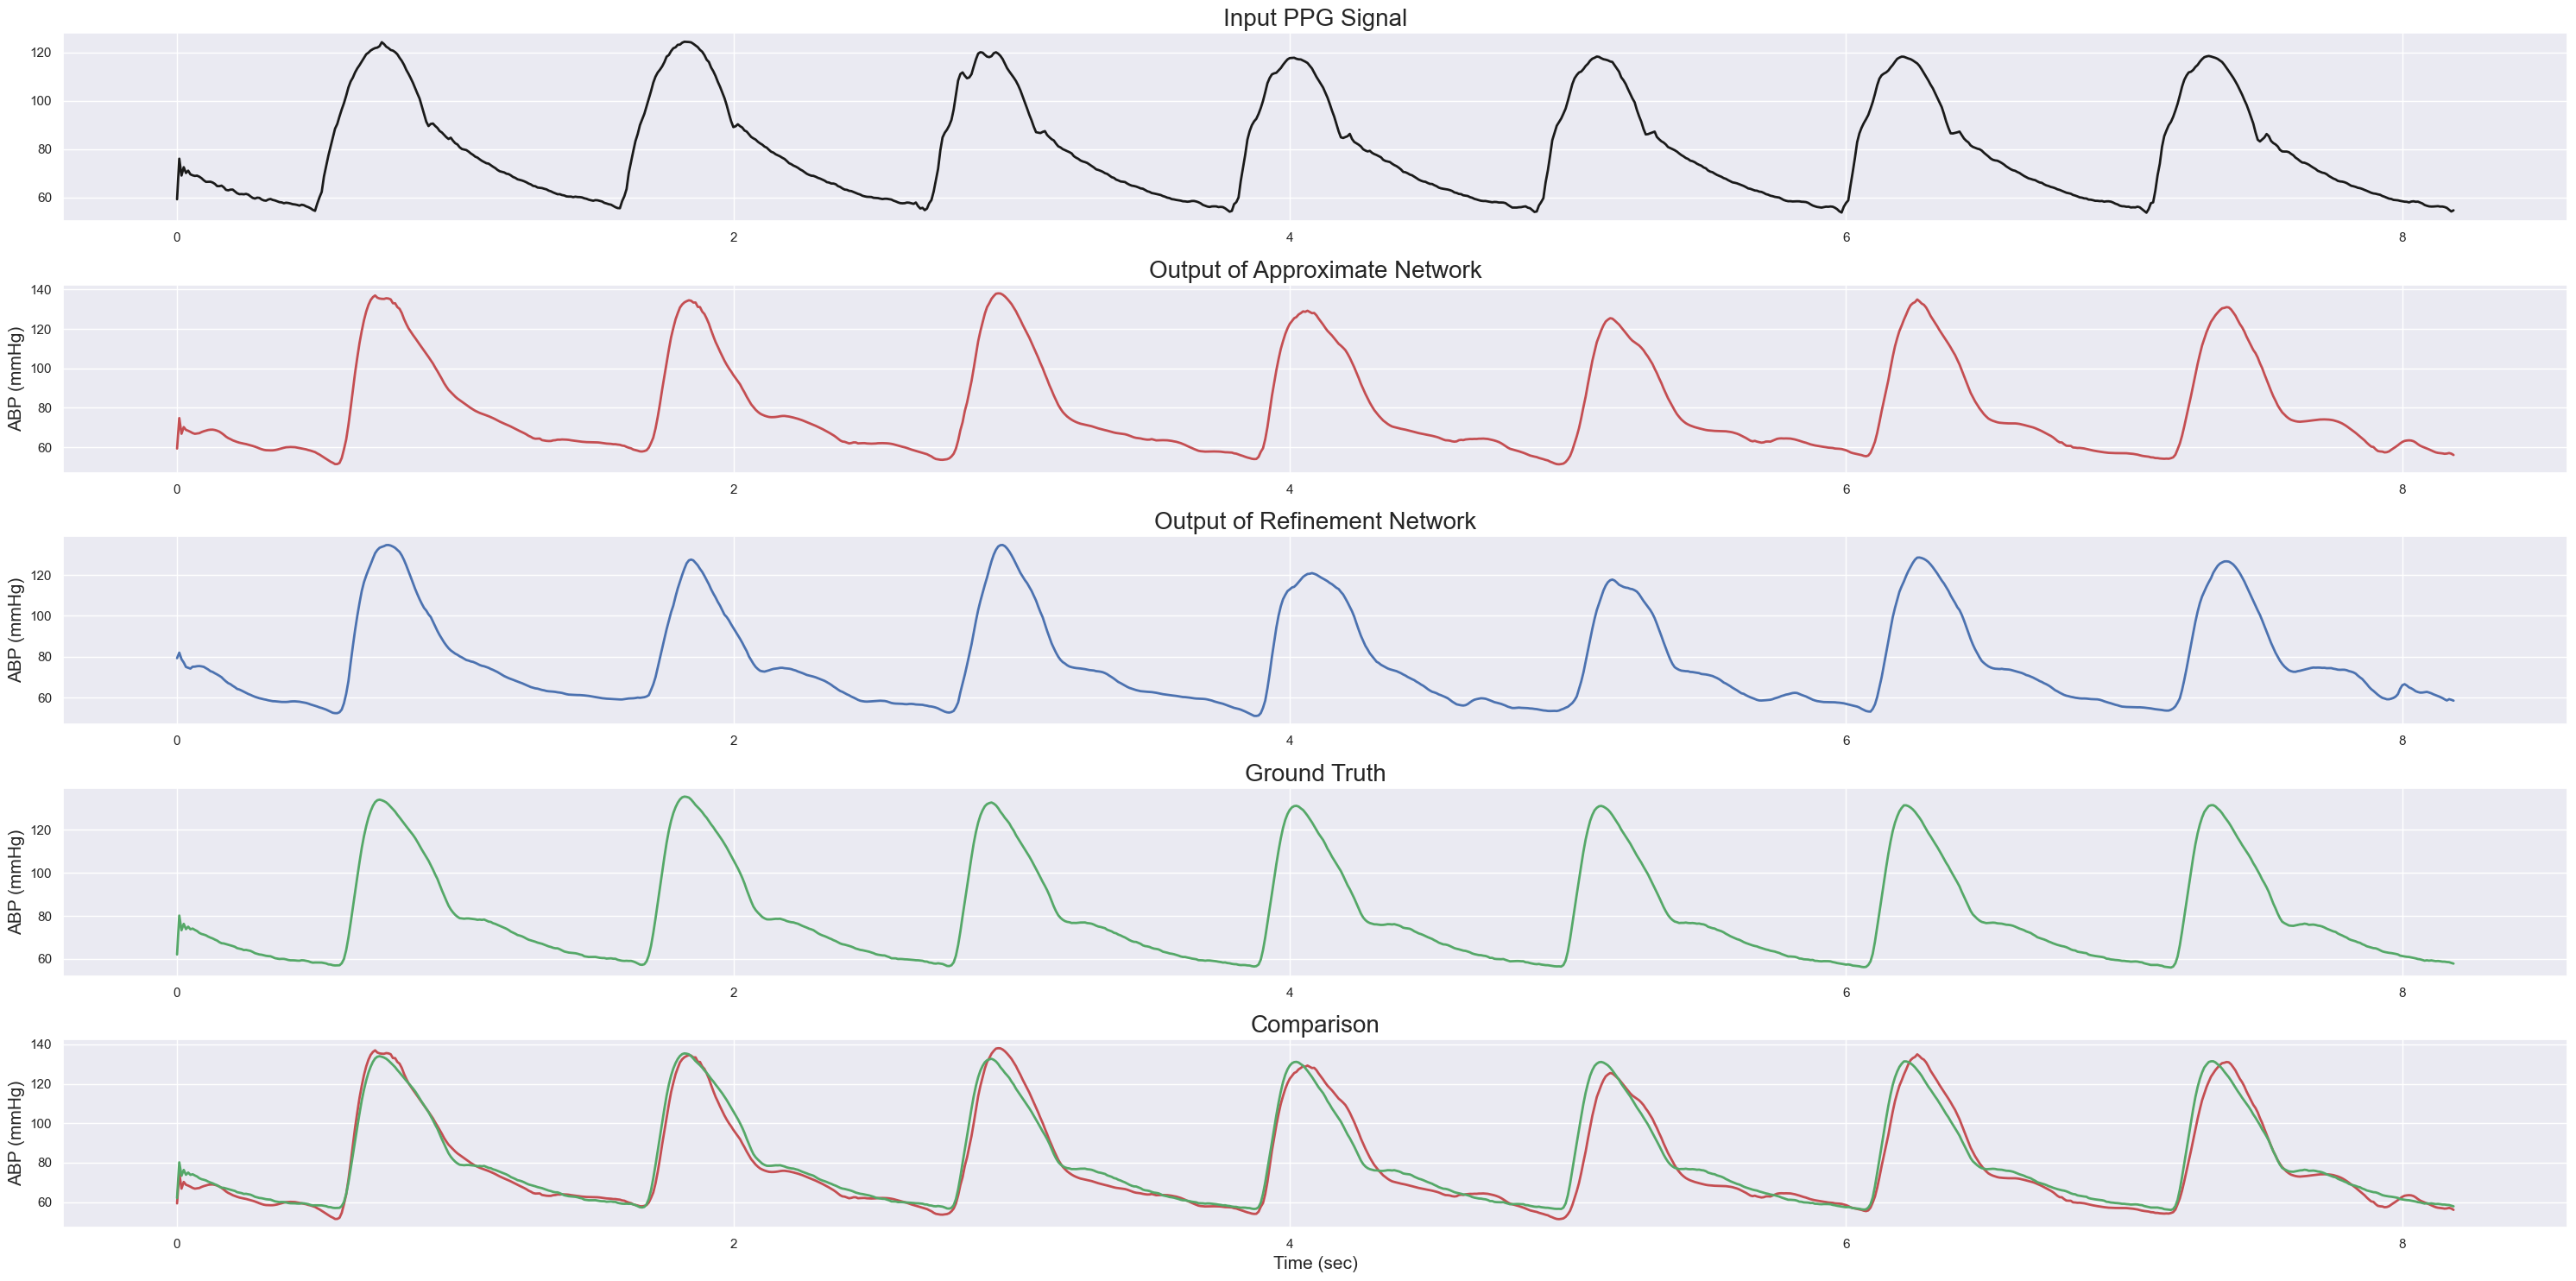

ValueError: invalid literal for int() with base 10: ''

In [27]:
#冻住前25层
from evaluate import predicting_ABP_waveform

predicting_ABP_waveform()

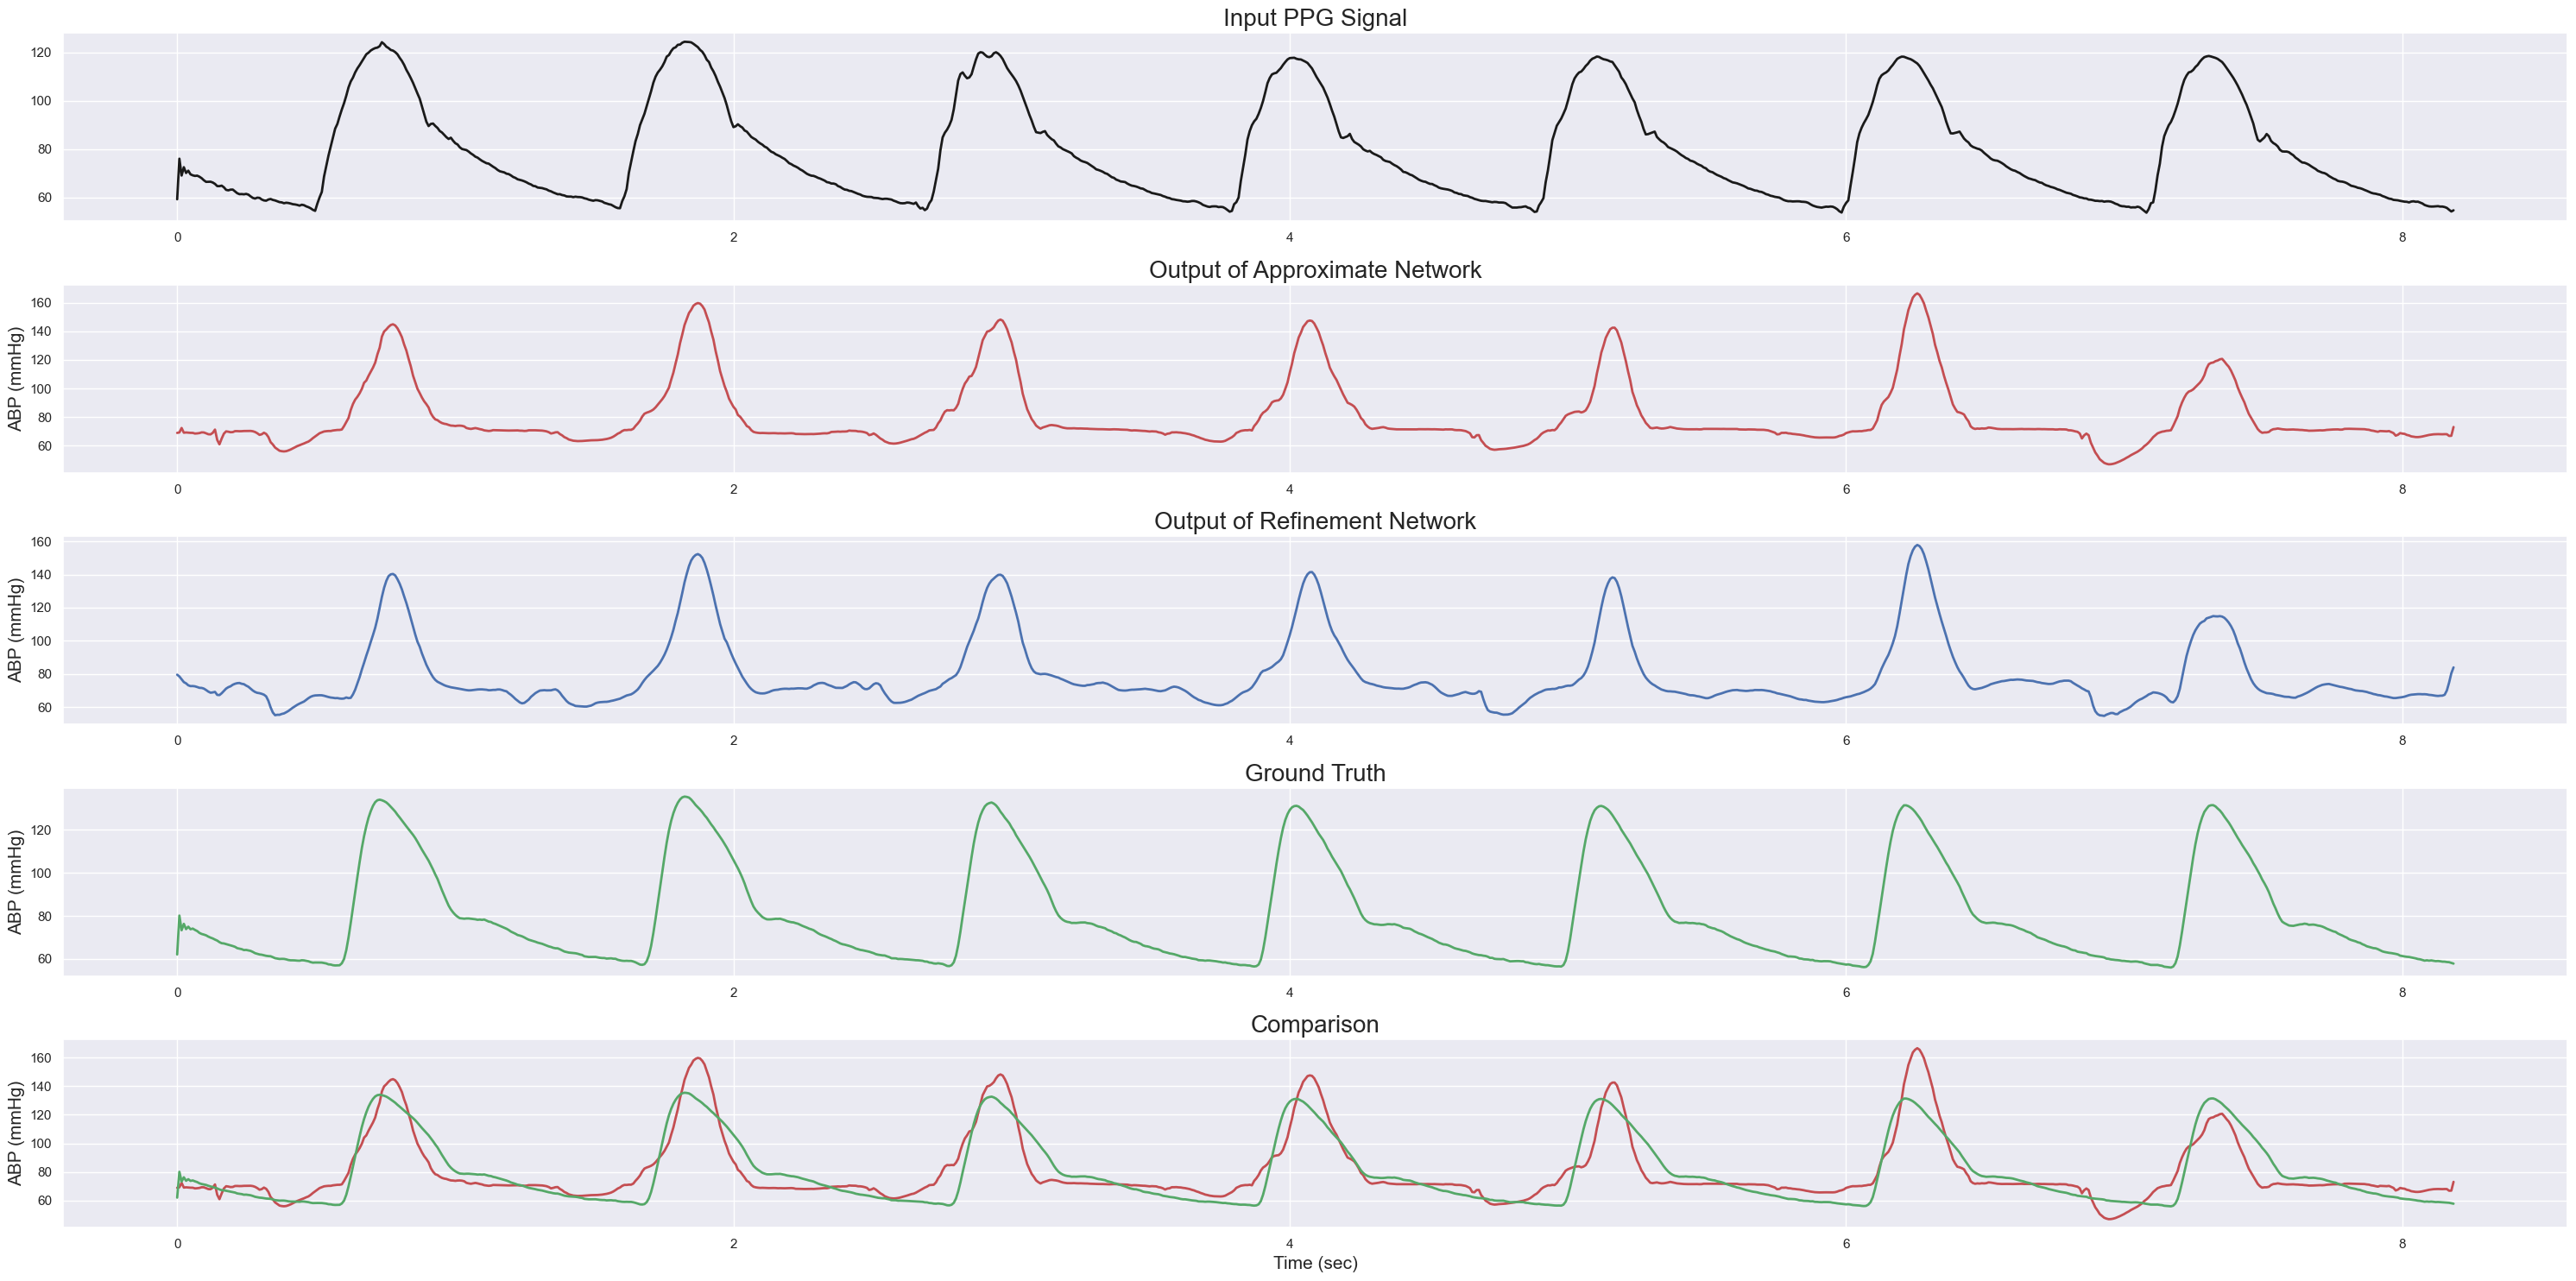

ValueError: invalid literal for int() with base 10: ''

In [20]:
# 不使用迁移，直接学习
from evaluate import predicting_ABP_waveform

predicting_ABP_waveform()

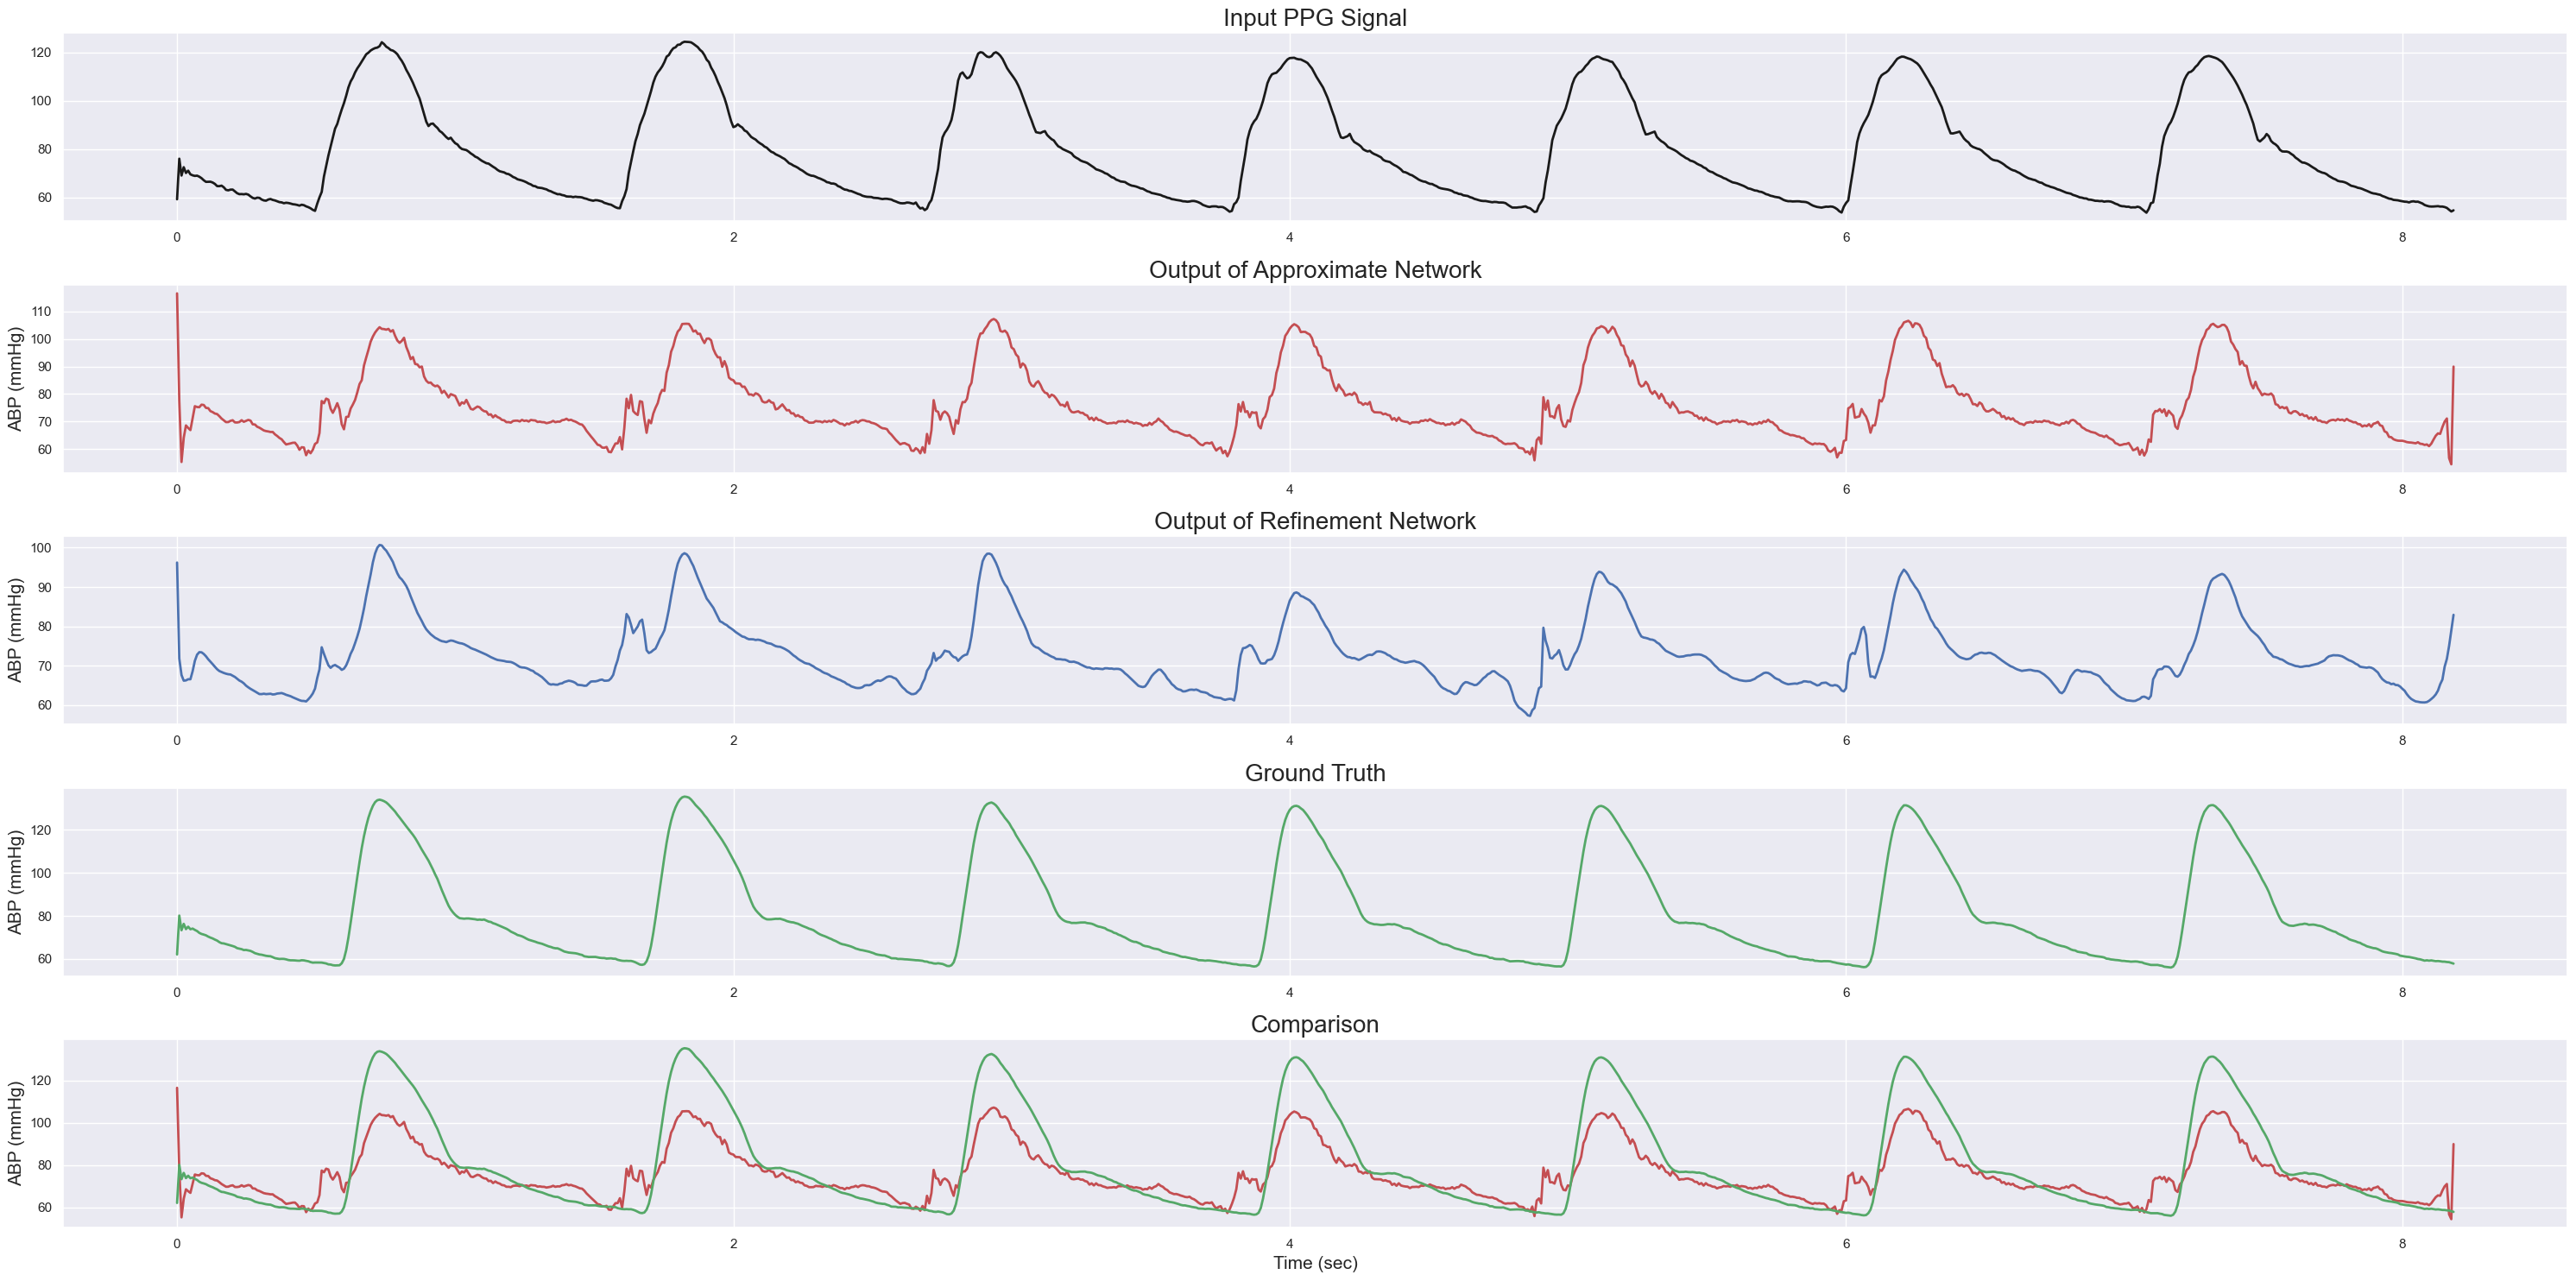

ValueError: invalid literal for int() with base 10: ''

In [17]:
from evaluate import predicting_ABP_waveform

predicting_ABP_waveform()

In [6]:
mdl1 = model_dict[mdlName1](length)             # create approximation network
mdl1.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_216 (Conv1D)             (None, 1024, 64)     256         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_216 (BatchN (None, 1024, 64)     256         conv1d_216[0][0]                 
__________________________________________________________________________________________________
conv1d_217 (Conv1D)             (None, 1024, 64)     12352       batch_normalization_216[0][0]    
___________________________________________________________________________________________

In [7]:
for layer in mdl1.layers:
    print(layer)
    # layer.trainable = False